In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 12.0, 8.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Concatenate, Dense, Activation, Reshape, Conv1D , Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization, Embedding, LSTM, UpSampling1D

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


CPU times: user 1.99 s, sys: 436 ms, total: 2.43 s
Wall time: 2.98 s


# Self-construct waveform

In [2]:
def standard(x,height,decay):
    y = height*np.exp(-x*decay)
    return y

def shifter(x,starts):
    L = int(starts*len(x))
    y = np.zeros(len(x))
    y[:L] = np.zeros(L) 
    y[L:] = x[:(len(x)-L)]
    return y

def comb_standard(x,second,height_1,decay_1,height_2,decay_2):
    L = int(second*len(x))
    y = np.zeros(len(x))
    y[:L] = standard(x[:L],height_1,decay_1)
    y[L:] = standard(x[:(len(x)-L)],height_2,decay_2)
    return y

def noiser(x,strength):
    y = x + np.random.normal(0,strength,len(x))
    return y

def noiser_long(x,strength):
    noise = np.random.normal(0,strength,len(x))
    y = x + np.cumsum(noise)*strength
    return y

def noiser_comb(x,sepfact,strength):
    L = int(sepfact*len(x))
    x[:L] = noiser(x[:L],strength)
    x[L:] = noiser_long(x[L:],strength)
    return x

def array_maker(entries):
    x = np.arange(0,1,1/4096)
    x = np.expand_dims(x,axis=0)
    x = np.tile(x,[entries,1])
    return x

def double(x,second,height_1,decay_1,height_2,decay_2,starts,sepfact=0.15,strength=0.02):
    y = comb_standard(x,second,height_1,decay_1,height_2,decay_2)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def single(x,height,decay,starts,sepfact=0.15,strength=0.02):
    y = standard(x,height,decay)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def event_creators_single(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(5,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_2(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(10,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_3(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.1)
        r = np.random.normal(4,1)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_sharp(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(100,20)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)    
    return x

def event_creators_double_equal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.01)
        q = np.random.normal(5,2)
        r = np.random.normal(1,0.01)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x
    
def event_creators_double_unequal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.2)
        q = np.random.normal(50,10)
        r = np.random.normal(1,0.2)
        s = np.random.normal(50,10)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

def event_creators_sharp_fat(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.015,0.001)
        p = np.random.normal(1,0.2)
        q = np.random.normal(100,20)
        r = np.random.normal(0.2,0.05)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

In [3]:
classes = 7
group = 5
training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3
    
def comb(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
#     six1,six2 = sep(six,5,portion)
#     seven1,seven2 = sep(seven,6,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

# def generator(x):
#     while 1:
#         beta = event_creators_single(1000)
#         ls = event_creators_sharp(1000)
#         dp_e = event_creators_double_equal(1000)
#         dp_ue = event_creators_double_unequal(1000)
#         lsbeta = event_creators_sharp_fat(1000)
        
#         alpha = event_creators_single_2(1000)
#         gamma = event_creators_single_3(1000)
        
#         z1, z2 = comb(beta,ls,dp_e,dp_ue,lsbeta,alpha,gamma,x)
#         s = np.random.permutation(np.arange(len(z2)))
#         z1 = z1[s]
#         z2 = z2[s]
# #         print(len(z1))
#         gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
#         for i in range(len(z2)):
#             d1 = np.expand_dims(z1[i],axis=0)
# #             p = gasf.transform(d1)
#             q = keras.utils.to_categorical(z2[i],classes)
#             r = normalize(d1,norm="l1")
#             yield r,q

# test = generator(2)
# # print(next(test)[0][0])
# print(next(test)[0][0].shape)
# # print(next(test)[0][1].shape)
# print(next(test)[1].shape)

# from pyts.visualization import plot_gasf
# plot_gasf(next(test)[0], image_size=128, overlapping=False, scale='-1')

In [4]:
def reader_pmtall(path):
    extra = np.arange(4096, 4480)
    
    tree = uproot.open(path)["tree"]
    pmtall = tree.array("PMTALL")
    pmtall = np.delete(pmtall, extra, axis=1)
    return pmtall

def reader(path,branch,number):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    column = column[:,number]
    return column

def reader_lone(path,branch):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    return column

def pmtall_pedestal(path):
    pedestal = reader(path,"Pedestal",0)
    pmtall = reader_pmtall(path)
    for i in range(len(pedestal)):
        pmtall[i] = -(pmtall[i]-pedestal[i])
    
    return pmtall

def generator(x):
    while 1:
        alpha = pmtall_pedestal("Alpha.root")
#         bad1 = pmtall_pedestal("BAD_DATA_QUALITY_1.root")
#         bad2 = pmtall_pedestal("BAD_DATA_QUALITY_2.root")
        piled = pmtall_pedestal("Piled_2.root")
        ls = pmtall_pedestal("LS.root")
        lsbeta = pmtall_pedestal("lsbeta.root")
        ref = pmtall_pedestal("RefPulse009.root")
        
        z1, z2 = comb(piled,ref,alpha,ls,lsbeta,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]

#         para_piled = parameters("Piled_2.root")
#         para_ref = parameters("RefPulse009.root")
#         para_alpha = parameters("Alpha.root")
#         para_ls = parameters("LS.root")
#         para_lsbeta = parameters("lsbeta.root")
        
#         z3, z4 = comb5(para_piled,para_ref,para_alpha,para_ls,para_lsbeta,x)        
#         z3 = z3[s] 
#         z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
#             s = np.expand_dims(q,axis=0)
            yield r,r

test = generator(0)
# print(next(test)[0][0])
print(next(test)[0].shape)
# print(next(test)[0][1].shape)
# print(next(test)[1].shape)

(1, 4096)


In [5]:
def multiple_inputs():
    feeder_1d = Input(shape=(4096,))
    model2 = Reshape((4096,1),input_shape=(4096,))(feeder_1d)
    model2 = Conv1D(32, kernel_size=64, strides=1,padding='same',activation="relu")(model2)
    model2 = MaxPooling1D(pool_size=2,padding='same')(model2)
    model2 = Conv1D(16, kernel_size=64, strides=1,padding='same',activation="relu")(model2)
    model2 = MaxPooling1D(pool_size=4,padding='same')(model2)
    
    model2 = Conv1D(16, kernel_size=64, strides=1,padding='same',activation="relu")(model2)
    model2 = UpSampling1D(4)(model2)
    model2 = Conv1D(32, kernel_size=64, strides=1,padding='same',activation="relu")(model2)
    model2 = UpSampling1D(2)(model2)
    model2 = Conv1D(1, kernel_size=64, strides=1,padding='same',activation="sigmoid")(model2)
    waveform_1d_out = Reshape((4096,),input_shape=(4096,1))(model2)
    
#     feeder_2d = Input(shape=(128,128))
#     model2 = Reshape((128,128,1),input_shape=(128,128))(feeder_2d)
#     model2 = Conv2D(64, kernel_size=(8,8),strides=4,padding='same')(model2)
#     model2 = MaxPooling2D(pool_size=2)(model2)
#     model2 = Activation("relu")(model2)
#     model2 = Conv2D(32, kernel_size=(4,4),strides=4,padding='same')(model2)
#     model2 = MaxPooling2D(pool_size=2)(model2)
#     model2 = Activation("relu")(model2)
#     model2 = Dropout(0.2)(model2)
#     model2 = Flatten()(model2)
# #     model2 = Dense(256,activation="relu")(model2)
# #     model2 = Dropout(0.3)(model2)
#     model2 = Dense(64,activation="relu")(model2)
#     model2 = Dropout(0.3)(model2)
#     model2 = Dense(64,activation="relu")(model2)
#     model2 = Dropout(0.3)(model2)
#     waveform_2d_out = Dense(7,activation="sigmoid")(model2)
    
#     feeder_para = Input(shape=(10,))
#     model3 = Dense(64,activation="relu")(feeder_para)
#     model3 = Dropout(0.2)(model3)
#     model3 = Dense(64,activation="relu")(model3)
#     model3 = Dropout(0.2)(model3)
# #     model3 = Dense(128,activation="relu")(model3)
# #     model3 = Dropout(0.2)(model3)
#     para_dense = Dense(7,activation="sigmoid")(model3)
    
#     x = keras.layers.concatenate([waveform_1d_out, waveform_2d_out])
#     x = Dense(256,activation="relu")(x)
#     x = Dropout(0.2)(x)
#     x = Dense(256,activation="relu")(x)
#     x = Dropout(0.2)(x)
#     main_output = Dense(7, activation='softmax', name='main_output')(x)
    
    model = Model(inputs=[feeder_1d],outputs=[waveform_1d_out])
    model.summary()
    
    return model

mult = multiple_inputs()
mult.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4096, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4096, 32)          2080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2048, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2048, 16)          32784     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 512, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 512, 16)           16400     
__________

Epoch 1/10
21430/21430 [==============================] - 1404s 65ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 2/10
21430/21430 [==============================] - 1314s 61ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/10
21430/21430 [==============================] - 1335s 62ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/10
21430/21430 [==============================] - 1327s 62ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/10
21430/21430 [==============================] - 1354s 63ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/10
21430/21430 [==============================] - 1357s 63ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/10
21430/21430 [==============================] - 1362s 64ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/10
21430/21430 [==============================] - 1318s 62ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/10
21430/21430 [==============================] - 1285s 60ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/10
21430/21430 [===

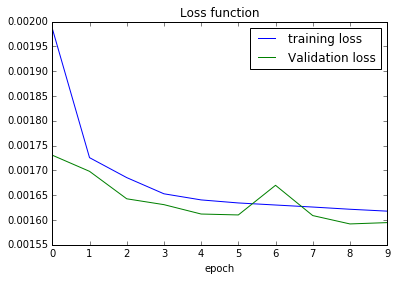

0.0015751806934321787


In [6]:
train_gen = generator(0)
val_gen = generator(1)
test_gen = generator(2)

steps_t = 21430
steps_vt = 3062

history = mult.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=10, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
print(history.history.keys())
# plt.figure()
# plt.title("Classification accuracy")
# plt.xlabel("epoch")
# plt.plot(history.history['acc'],label="training accuracy")
# plt.plot(history.history['val_acc'],label="Validation accuracy")
# plt.legend(loc=4)
# plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

# print("Classification accuracy =",history.history['val_acc'][-1])

# mult.save("GPU_CNN.h5")

score = mult.evaluate_generator(test_gen,steps=1531)
print(score)

In [8]:
mult.save("thief_5.h5")